# SuperAI Season 4 - Level 1 Hackathon - Image Search

## Unzip Datasets

In [ ]:
!unzip /content/drive/MyDrive/SuperAI_SS4_Recap/SuperAI_SS4_Level_1/Hack_1_Image_Search/datasets/image-search.zip

In [ ]:
!mkdir /content/database

## Include Libraries

In [ ]:
from PIL import Image
import tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import torch

## Explore Datasets

## Rename & Type Images

In [ ]:
# Directory containing your images
image_dir = '/content/queries/queries'

# List all files in the directory
files = os.listdir(image_dir)

# Iterate through the files, assuming they are named as 0.jpg, 1.jpg, etc.
for i, file_name in enumerate(sorted(files)):

    if file_name.endswith('.jpg'):  # Only process .jpg files
        # Construct the new file name with leading zeros
        index = int(file_name.split('.')[0])
        new_file_name = f'query_{index:02}.jpg'

        # Get the full paths
        old_file_path = os.path.join(image_dir, file_name)
        new_file_path = os.path.join(image_dir, new_file_name)

        # Rename the file
        os.rename(old_file_path, new_file_path)

        print(f'Renamed: {file_name} to {new_file_name}')

In [ ]:
queries_path = glob.glob('/content/queries/queries/*')

for path in queries_path :
    # Open the PNG image in palette mode ('P')
    png_image = Image.open(path)

    # Convert the image mode from 'P' (palette) to 'RGB'
    rgb_image = png_image.convert('RGB')

    # Save the image as a JPEG
    rgb_image.save(path , format='JPEG')

### Query Images

In [ ]:
queries_path = glob.glob('/content/queries/queries/*')

In [ ]:
queries_path.sort()
queries_path

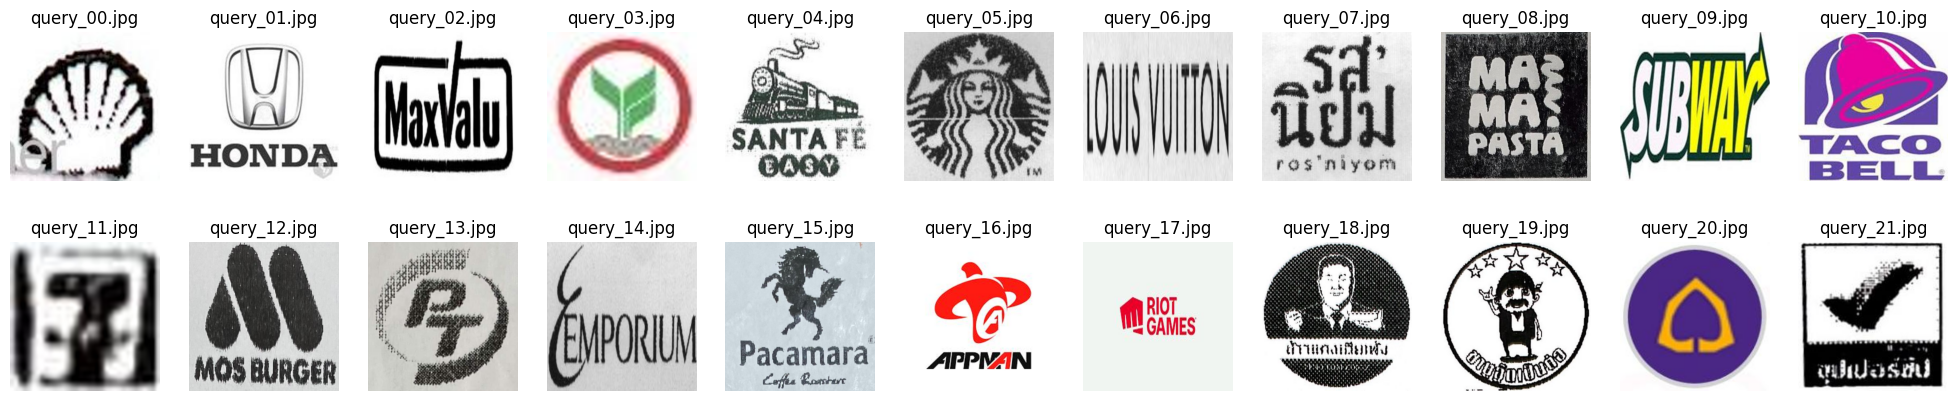

In [ ]:
num_row = 2
num_column = 11

fig , axes = plt.subplots(num_row , num_column , figsize = (25 , 5))

for idx , path in enumerate(queries_path) :

    image = Image.open(path)
    image = image.resize((336 , 336))

    axes[idx // num_column , idx % num_column].imshow(image)
    axes[idx // num_column , idx % num_column].set_title(path.split('/')[-1])
    axes[idx // num_column , idx % num_column].axis('off')

### Test Image

In [ ]:
test_path = glob.glob('/content/test/images/*')

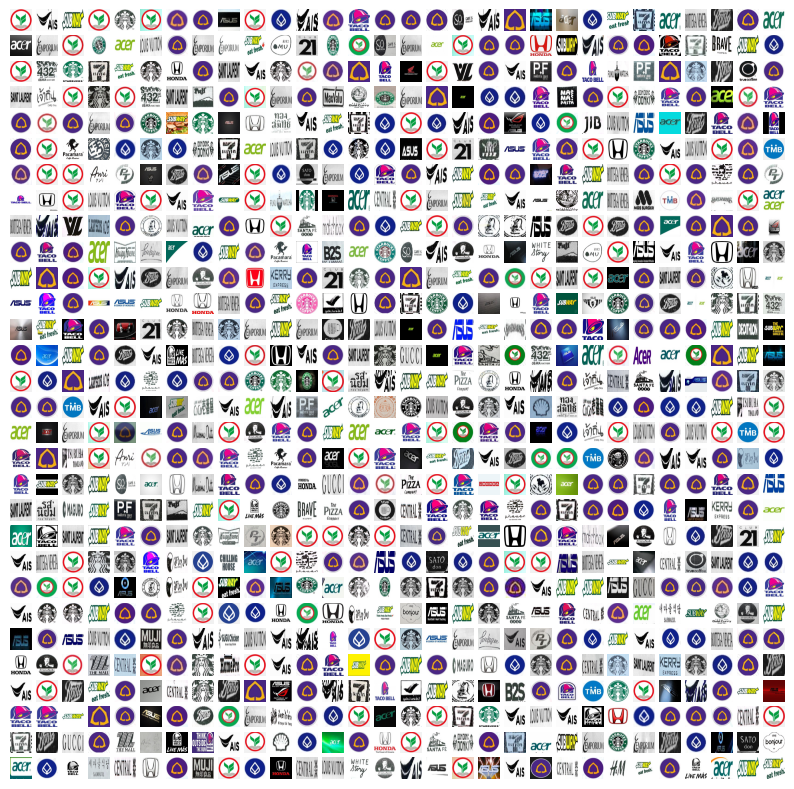

In [ ]:
num_row = 30
num_column = 30

fig , axes = plt.subplots(num_row , num_column , figsize = (10 , 10))

for idx , path in enumerate(test_path[ : num_row * num_column]) :

    image = Image.open(path)
    image = image.resize((336 , 336))

    axes[idx // num_column, idx % num_column].imshow(image)
    axes[idx // num_column, idx % num_column].axis('off')

## CLIP - Create Query Matrix

In [ ]:
from transformers import AutoProcessor, CLIPVisionModel

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
queries_path = glob.glob('/content/queries/queries/*')
queries_path.sort()

In [ ]:
queries_path

In [ ]:
images = [Image.open(file_path) for file_path in queries_path]

In [ ]:
query_inputs = processor(images = images , return_tensors = 'pt')

In [ ]:
query_inputs['pixel_values'].shape

torch.Size([22, 3, 224, 224])

In [ ]:
outputs = model(**query_inputs.to(device))

In [ ]:
query_matrix = outputs['pooler_output'].cpu().detach().numpy()

with open ('/content/database/query_matrix.npy' , 'wb') as file :

    np.save(file , query_matrix)

## CLIP - Image Similarity

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv' , index_col = 'img_file')
submission.head()

,class
img_file,
64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,12.0
c6df1385-382a-4428-b41e-f2d729b90c87.jpg,22.0
af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,22.0
3fc8998e-0324-426c-8233-6b76abc7e200.jpg,NaN
309d1085-0d11-4411-9555-b24cc8fcee02.jpg,NaN


In [ ]:
test_path = glob.glob('/content/test/images/*')
test_path

In [ ]:
with open ('/content/database/query_matrix.npy' , 'rb') as file :

    query_matrix = np.load(file)

In [ ]:
def cosine_similarity (A , B) :

    return np.dot(A , B) / (np.linalg.norm(A) * np.linalg.norm(B))

In [ ]:
def classified (current_vector) :

    similarity_list = []

    for  query_vector in query_matrix :

        similarity = cosine_similarity(A = query_vector.squeeze() , B = current_vector.squeeze())
        similarity_list.append(similarity)

    similarity_array = np.array(similarity_list).squeeze()

    idx = np.argmax(similarity_array  , axis = 0)
    max_similarity = similarity_array[idx]

    if(max_similarity < 0.75) :

        return 22

    else : return idx


In [ ]:
for idx in range(1120) :

    image = Image.open(test_path[idx])

    inputs = processor(images = image , return_tensors = 'pt')
    outputs = model(**inputs.to(device))

    current_matrix = outputs['pooler_output'].cpu().detach().numpy()
    answer = classified(current_matrix)

    submission.loc[test_path[idx].split('/')[-1] , 'class'] = answer

In [ ]:
submission['class'].value_counts()

,count
class,
22.0,635
20.0,168
9.0,72
10.0,68
5.0,43
1.0,39
6.0,34
14.0,21
18.0,10


In [ ]:
submission.to_csv('/content/submission.csv')